# Introduction

Today's seminar focuses on clustering and the tightly associated problem of dimensionality reduction. Remember, both tasks are the so-called unsupervised machine learning problems.

In particular, we will study these topics with applications to scRNA-seq data analysis.

## Resources

* Excellent [workshop](https://chanzuckerberg.github.io/scRNA-python-workshop/intro/about.html) and a [course](https://www.singlecellcourse.org) about scRNA-seq analysis, and the list of [best practices](https://www.embopress.org/doi/full/10.15252/msb.20188746) (as of 2019)
* [Comprehensive review](https://www.nature.com/articles/s41592-021-01171-x) : The triumphs and limitations of computational methods for scRNA-seq (available via SciHub)
* Tutorials from the mainstream scRNA-seq packages: [scanpy](https://scanpy.readthedocs.io/en/stable/tutorials.html) and [seurat](https://satijalab.org/seurat/)


Please leave feedback after each seminar [here](https://forms.gle/8QdTovbxJsEjiBst8).

# Dataset preparation

Experimental scRNA-seq data is usually published as counts matrices, and this format is sufficient for the current seminar's purposes. In particular, we will work with 20k peripheral blood mononuclear cells (PBMCs) obtained by [10x Genomics](https://www.10xgenomics.com/resources/datasets/20-k-human-pbm-cs-3-ht-v-3-1-chromium-x-3-1-high-6-1-0).

Unfortunately, we don't have time for in-depth coverage of scRNA-seq experiments and the preprocessing steps required to get such matrices (see links for details).


## Download

First, let's download and unpack the data:

In [ ]:
!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_PBMC_3p_HT_nextgem_Chromium_X/20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.tar.gz
!tar -xzf 20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.tar.gz

--2024-12-02 17:09:21--  https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_PBMC_3p_HT_nextgem_Chromium_X/20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209851553 (200M) [application/x-tar]
Saving to: ‘20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.tar.gz’

20k_PBMC_3p_HT_next 100%[===================>] 200.13M  94.0MB/s    in 2.1s    

2024-12-02 17:09:23 (94.0 MB/s) - ‘20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.tar.gz’ saved [209851553/209851553]



In [ ]:
!ls filtered_feature_bc_matrix

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz


Install `scanpy` and load the data:

In [ ]:
# current plt is not supported by the scanpy
!python3 -m pip uninstall -y matplotlib
!python3 -m pip install matplotlib==3.6.3 scanpy

Found existing installation: matplotlib 3.8.0
Uninstalling matplotlib-3.8.0:
  Successfully uninstalled matplotlib-3.8.0
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=351b736faee01b775648aa40cf0e1e0194dd8387ecc244874487e0b80380523e
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built ses

In [ ]:
import scanpy as sc

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3

adata = sc.read_10x_mtx(
    'filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',      # use gene symbols for the variable names (variables-axis index)
    cache=True                     # write a cache file for faster subsequent reading
)
# Make all gene names unique (symbols MUST be unique by but in reality...)
adata.var_names_make_unique()

adata

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 23837 × 36601
    var: 'gene_ids', 'feature_types'

Note that `AnnData` is not a simple data frame and is composed of several related objects:

![AnnData](https://chanzuckerberg.github.io/scRNA-python-workshop/figures/anndata.svg)

See [this](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) tutorial if you want to know more.

## Filtering

In a typical workflow, we need to remove both cells with a low number of detected genes (empty droplets) and genes with a low number of source cells (potential artifacts).

In [ ]:
# Calculate common QC metrics (see docs for details)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

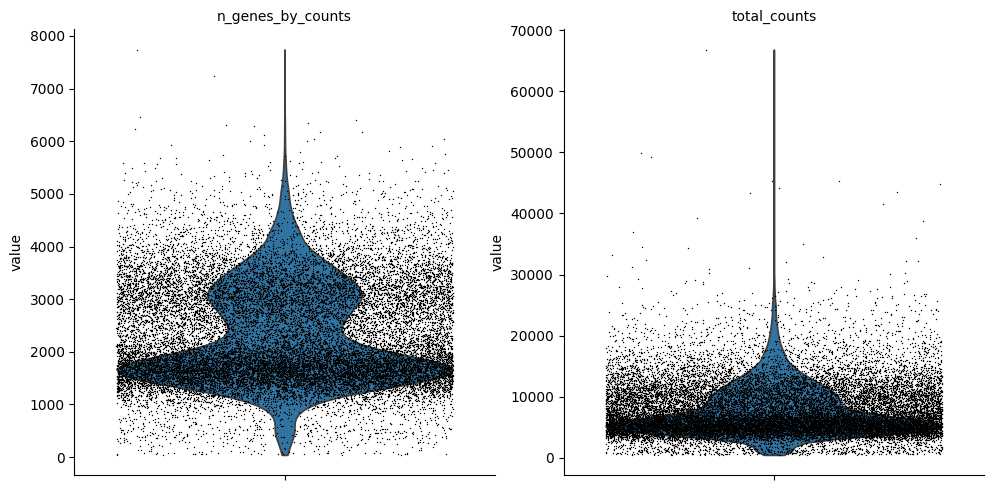

In [ ]:
# Plot the result
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts'],
    jitter=0.4, multi_panel=True
)

In [ ]:
# Warning! Very harsh thresholds to keep comp. time small
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=100)
adata

filtered out 851 cells that have less than 1000 genes expressed
filtered out 22048 genes that are detected in less than 100 cells


AnnData object with n_obs × n_vars = 22986 × 14553
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [ ]:
adata.var

,gene_ids,feature_types,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL627309.5,ENSG00000241860,Gene Expression,1356,0.062130,94.311365,1481.0,1346
LINC01409,ENSG00000237491,Gene Expression,1748,0.080463,92.666862,1918.0,1728
LINC01128,ENSG00000228794,Gene Expression,1304,0.059236,94.529513,1412.0,1290
LINC00115,ENSG00000225880,Gene Expression,353,0.015061,98.519109,359.0,351
FAM41C,ENSG00000230368,Gene Expression,274,0.011830,98.850526,282.0,274
...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,169,0.007174,99.291018,171.0,168
AL592183.1,ENSG00000273748,Gene Expression,1683,0.075807,92.939548,1807.0,1668
AC240274.1,ENSG00000271254,Gene Expression,781,0.036582,96.723581,872.0,777
AC004556.3,ENSG00000276345,Gene Expression,2646,0.122583,88.899610,2922.0,2638


In [ ]:
adata.obs['n_genes']

,n_genes_by_counts,total_counts,n_genes
AAACCCAAGAGCAGCT-1,3085,9203.0,3085
AAACCCACAATACCTG-1,1845,5705.0,1845
AAACCCACACAACCGC-1,2937,8877.0,2937
AAACCCACACACAGAG-1,4854,22005.0,4854
AAACCCACAGATCATC-1,3264,12444.0,3264
...,...,...,...
TTTGTTGGTTCAAGGG-1,1541,5318.0,1541
TTTGTTGTCACCTGGG-1,1880,5073.0,1880
TTTGTTGTCATTGAGC-1,1696,6433.0,1696
TTTGTTGTCCGATGTA-1,3787,12527.0,3787


Moreover, the mitochondrial RNA level is also a critical QC metric as they are frequently indicative of dying/perforated cells. Other standard metrics include the number of expressed genes and the total number of sequenced fragments per cell.

In [ ]:
mask = adata.var_names.str.startswith('MT-')
print(f"Mito genes: {adata.var_names[mask].tolist()}")

adata.var['mt'] = mask

Mito genes: ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


In [ ]:
adata.var_names

Index(['AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115', 'FAM41C', 'NOC2L',
       'KLHL17', 'PLEKHN1', 'HES4', 'ISG15',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'MAFIP', 'AL354822.1',
       'AL592183.1', 'AC240274.1', 'AC004556.3', 'AC007325.4'],
      dtype='object', length=14553)

In [ ]:
# Calculate common QC metrics (see docs for details)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

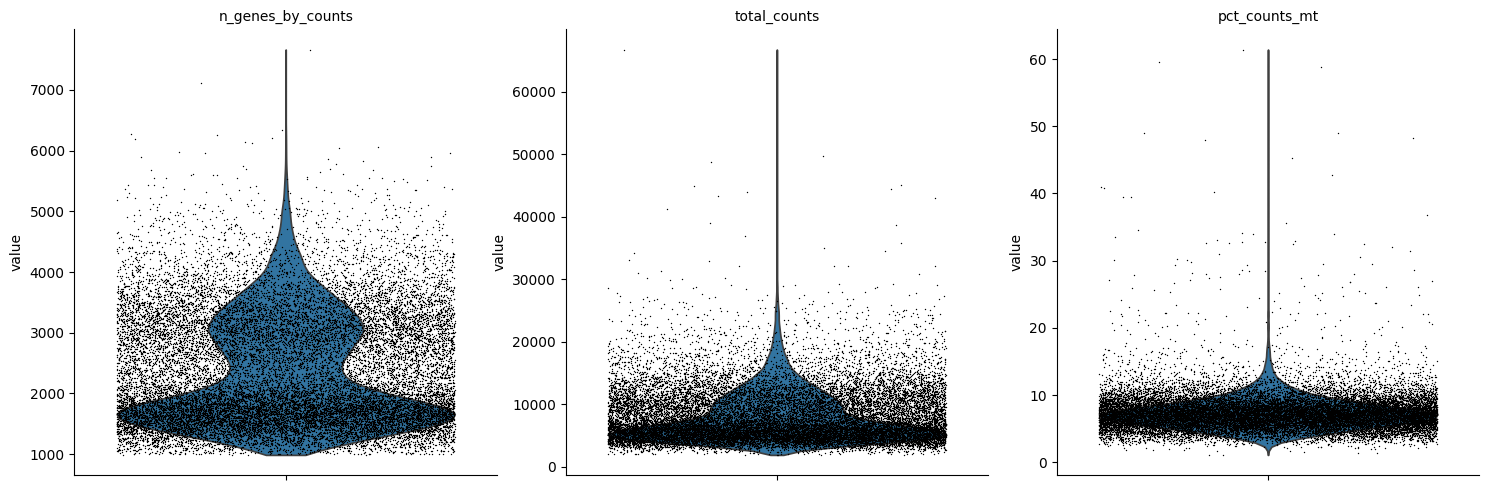

In [ ]:
# Plot the result
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True
)

In [ ]:
# Apply filters
adata = adata[adata.obs.n_genes_by_counts < 5_000, :]
adata = adata[adata.obs.total_counts < 25_000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata

View of AnnData object with n_obs × n_vars = 22548 × 14553
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt'

In [ ]:
# Normalize the data to CPM & take the log
sc.pp.normalize_total(adata, target_sum=1e6) # sum(cell counts) = 1e6
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


We aren't done yet. Before moving on, we need to eliminate genes that are, in some sense, too ordinary. For example, the expression of housekeeping genes and other low-variance genes is comparable in many cells. Therefore their information value is negligible, and we can save a lot of computations by removing them early on.

However, if you want 100% accurate results - feel free to keep everything as is.

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=7, min_disp=0.5)

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


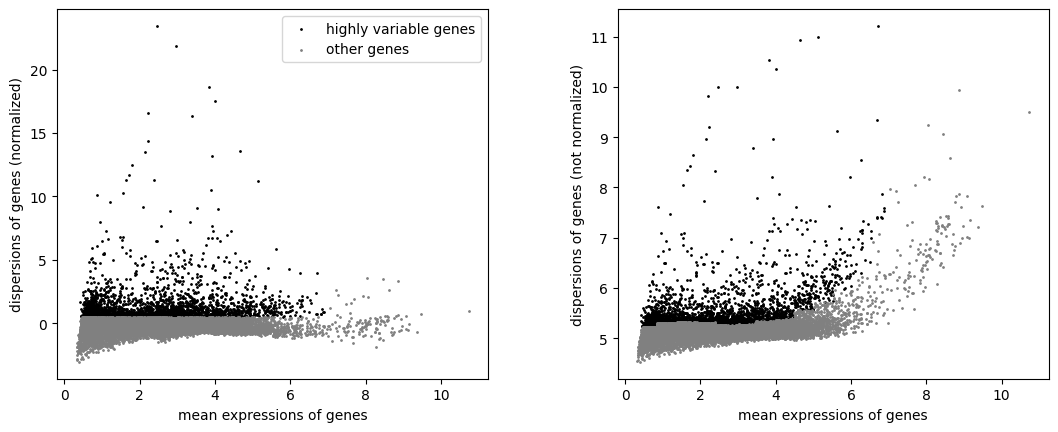

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 22548 × 2439
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Finally, scale the data to zero mean and unit variance:

In [ ]:
sc.pp.scale(adata, max_value=10) # clip values > 10

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Manifold learning (dimensionality reduction)

**sklearn-docs:** [link](https://scikit-learn.org/stable/modules/manifold.html)

Manifold learning is a collection of non-linear dimensionality reduction techniques. They assume that high-dimensional data may have a simpler internal structure, and seek to find a projection onto a lower-dimensional space that preserves that structure (in some sense).

*What is the difference between PCA and Manifold learning?*

In [ ]:
import numpy as np
# Subsample to speed up the analysis
ind = np.random.choice(np.arange(len(adata.X)), 2_000, replace=False)

X = adata.X[ind].copy()
print(f"Cells vs Genes: {X.shape}")

Cells vs Genes: (2000, 2439)


In [ ]:
from sklearn.manifold import Isomap, MDS, TSNE, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.decomposition import PCA

# Set of models to work with
embeddings = {
    "Isomap embedding": Isomap(n_components=2),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=100),
    "t-SNE embedding": TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42),
    "Spectral embedding": SpectralEmbedding(n_components=2, random_state=32),
    "LLE embedding": LocallyLinearEmbedding(n_components=2, method="modified"),
    "PCA": PCA(n_components=2)
}

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


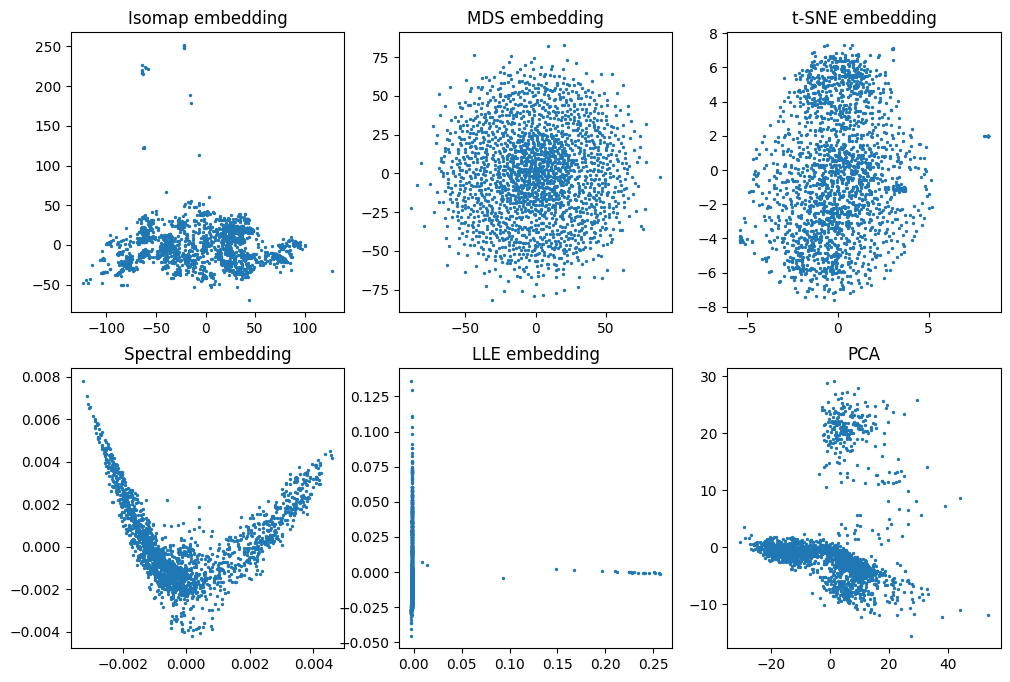

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

assert len(axes) == len(embeddings)

for ax, (name, model) in zip(axes, embeddings.items()):
  ax.set_title(name)
  transformed = model.fit_transform(X)
  ax.scatter(transformed[:, 0], transformed[:, 1], s=2)

We won't cover these methods in detail because the only rule is to use (and understand) the algorithm that works best on your data.

Anyway. What's about the full-scale `scanpy` PCA?

computing PCA
    with n_comps=50
    finished (0:00:15)


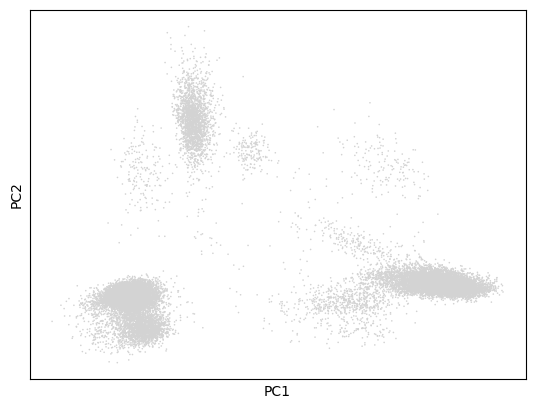

In [ ]:
sc.tl.pca(adata)
sc.pl.pca(adata)

The result is pretty similar to what we got earlier.

Another useful trick with the PCA is to understand how many components are required to describe the observed data variance:

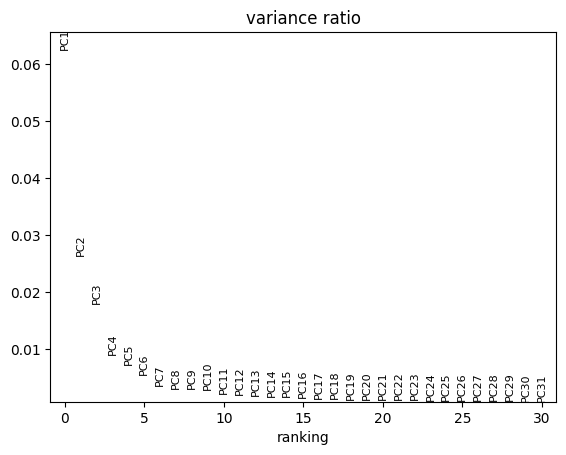

In [ ]:
sc.pl.pca_variance_ratio(adata)

sklearn version:

In [ ]:
pca = PCA(n_components=40, random_state=123).fit(adata.X)

In [ ]:
import matplotlib.pyplot as plt

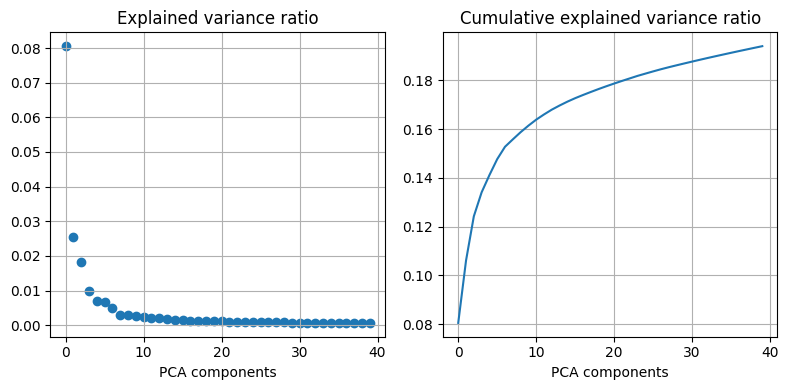

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize = (8, 4))

axes[0].scatter(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
axes[0].set_title("Explained variance ratio")

cumulative = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(cumulative)
axes[1].set_title("Cumulative explained variance ratio")

for ax in axes:
  ax.grid()
  ax.set_xlabel("PCA components")

fig.tight_layout()
fig.show()

Note, in each task, there might be a set of more sophisticated embedding algorithms. For example, the graph-based UMAP is quite popular in scRNA-seq analysis:

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


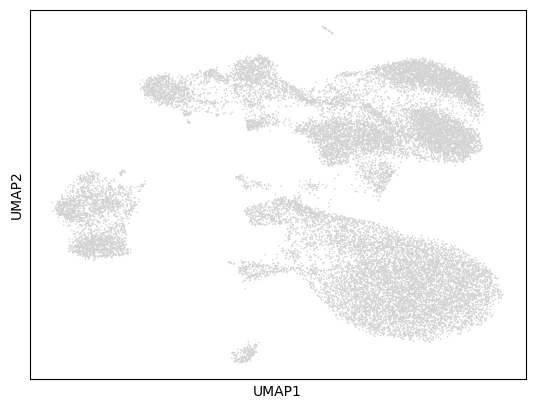

In [ ]:
sc.pl.umap(adata)

# Clustering

Loosely speaking, clustering algorithms try to find groups of elements in a way to maximize the dissimilarity between groups and similarity within each group. The problem is, of course, how to measure the similarity and find the best combination of items, which is an NP-hard optimization problem.

As in the case of dimensionality reduction, there are many options, and the specific choice usually depends on the problem being solved.

In [ ]:
# Subsample to speed up the analysis
sample = sc.pp.subsample(adata, n_obs=5_000, copy=True)
sample

AnnData object with n_obs × n_vars = 5000 × 2439
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift

# Cluster elements
algorithms = [
    ("K-means", KMeans(n_clusters=10, random_state=12)),
    ("Agglomerative Clustering", AgglomerativeClustering(n_clusters=10)),
    # ("Mean Shift", MeanShift()) # Too long
]

for name, algo in algorithms:
  print(name)
  clustering = algo.fit(sample.X)
  sample.obs[name] = clustering.labels_
  # -> category dtype
  sample.obs[name] = sample.obs[name].astype('category')

K-means
Agglomerative Clustering


Here is the Leiden graph clustering method (a typical scRNA-seq choice):

In [ ]:
!python3 -m pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.0 MB/s eta 0:00:00


In [ ]:
# Recalculate neighbors & the UMAP
sc.pp.neighbors(sample)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:48)


In [ ]:
# Run the Leiden clustering
sc.tl.leiden(sample, resolution=0.5)

running Leiden clustering


<ipython-input-42-418423a48df3>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sample, resolution=0.5)


    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


Let's plot the results:

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


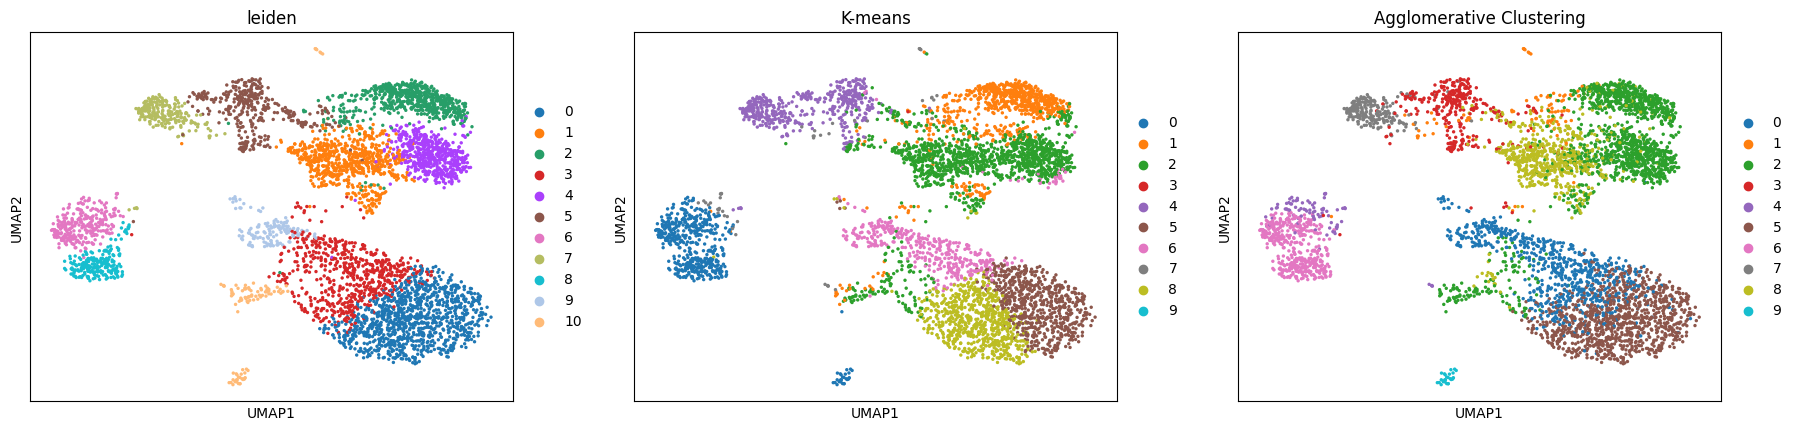

In [ ]:
sc.pl.umap(
    sample,
    color=['leiden', 'K-means', 'Agglomerative Clustering']
)